# Part(1): Classification

В этом выпуске:
- Попробуем использовать признаки для решения задачи классификации
- Cравним качество для разных подходов
- Познакомимся с интерфейсом библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (23, 9)

## 1. Загрузка данных

Для прмиера будем использовать датасет [Human Activity Recognition Using Smartphones](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)

TLDR:
1. Данные от 30 добровольцев от датчиков смартфона
3. Виды активностей: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING
4. Данные нарезаны скользящим окнос в 2.56с с 50% перекрытием (128 точек в окне)
5. Деление на train/test по людям


### Загрузка

In [2]:
import zipfile
import wget

wget.download("http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip")
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

-1 / unknown

In [2]:
x_train_sig = list(np.loadtxt("UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt", dtype="float32"))
x_test_sig = list(np.loadtxt("UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt", dtype="float32"))
y_train = np.loadtxt("UCI HAR Dataset/train/y_train.txt").astype(int)
y_test = np.loadtxt("UCI HAR Dataset/test/y_test.txt").astype(int)
activity_labels = np.array(pd.read_csv("UCI HAR Dataset/activity_labels.txt", header=None, delimiter=" "))[:, 1]

In [3]:
len(x_train_sig), len(y_train), len(x_test_sig), len(y_test)

(7352, 7352, 2947, 2947)

In [4]:
x_train_sig[0].shape

(128,)

### Посмотрим визуальн она разные классы


In [5]:
activity_labels

array(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING',
       'STANDING', 'LAYING'], dtype=object)

Вид активности: LAYING


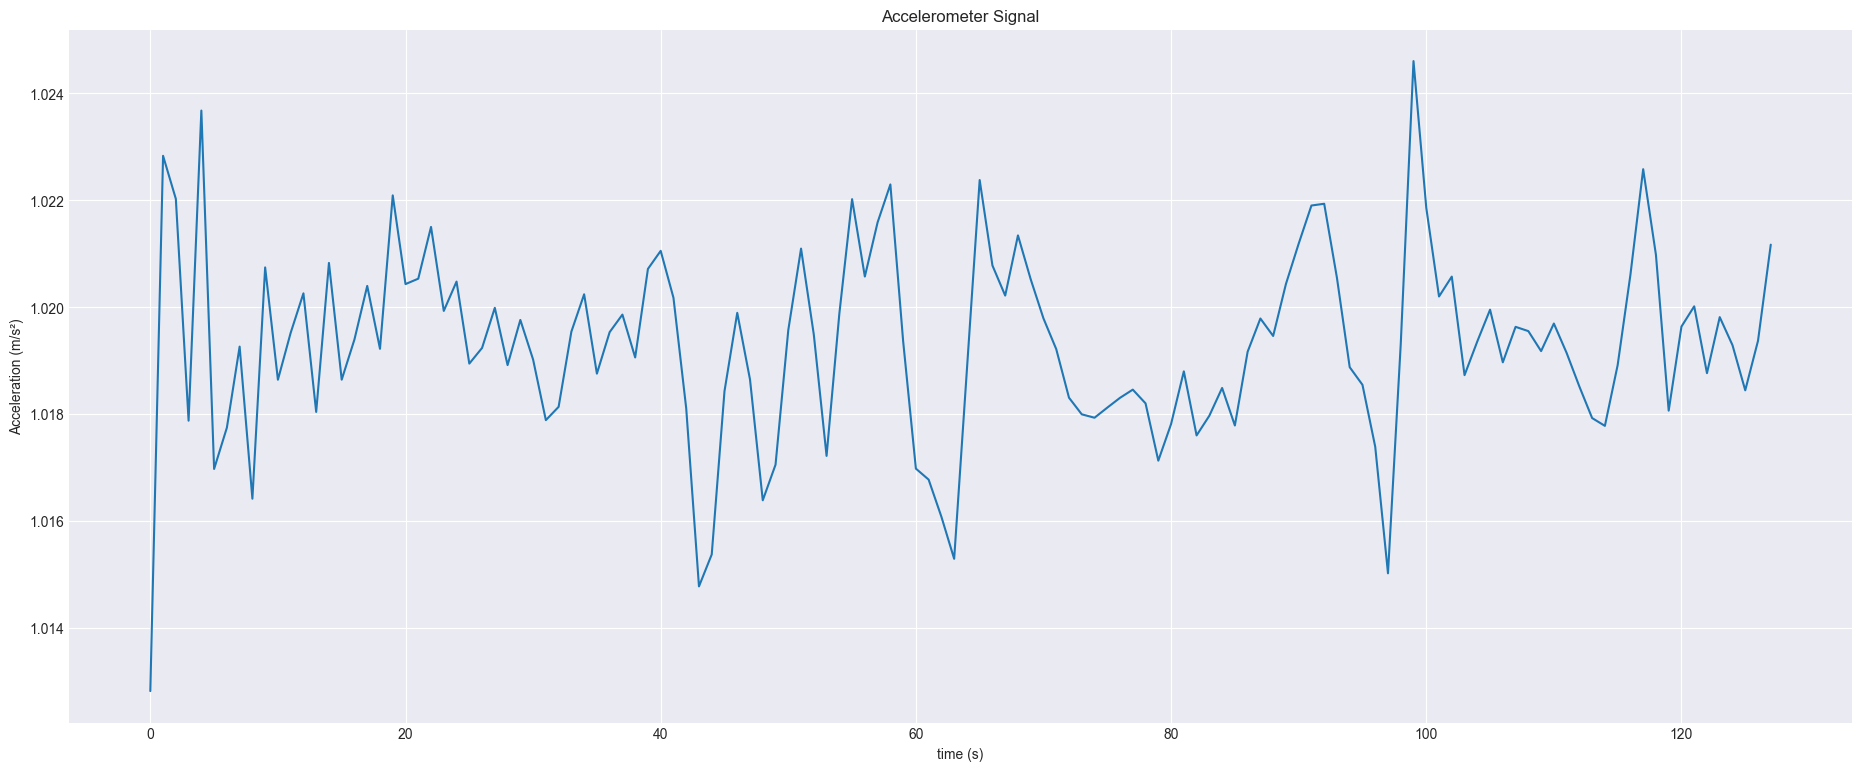

In [6]:
idx = 0
plt.plot(x_train_sig[idx])
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
print(f"Вид активности: {activity_labels[y_train[idx]]}")

Вид активности: WALKING_UPSTAIRS


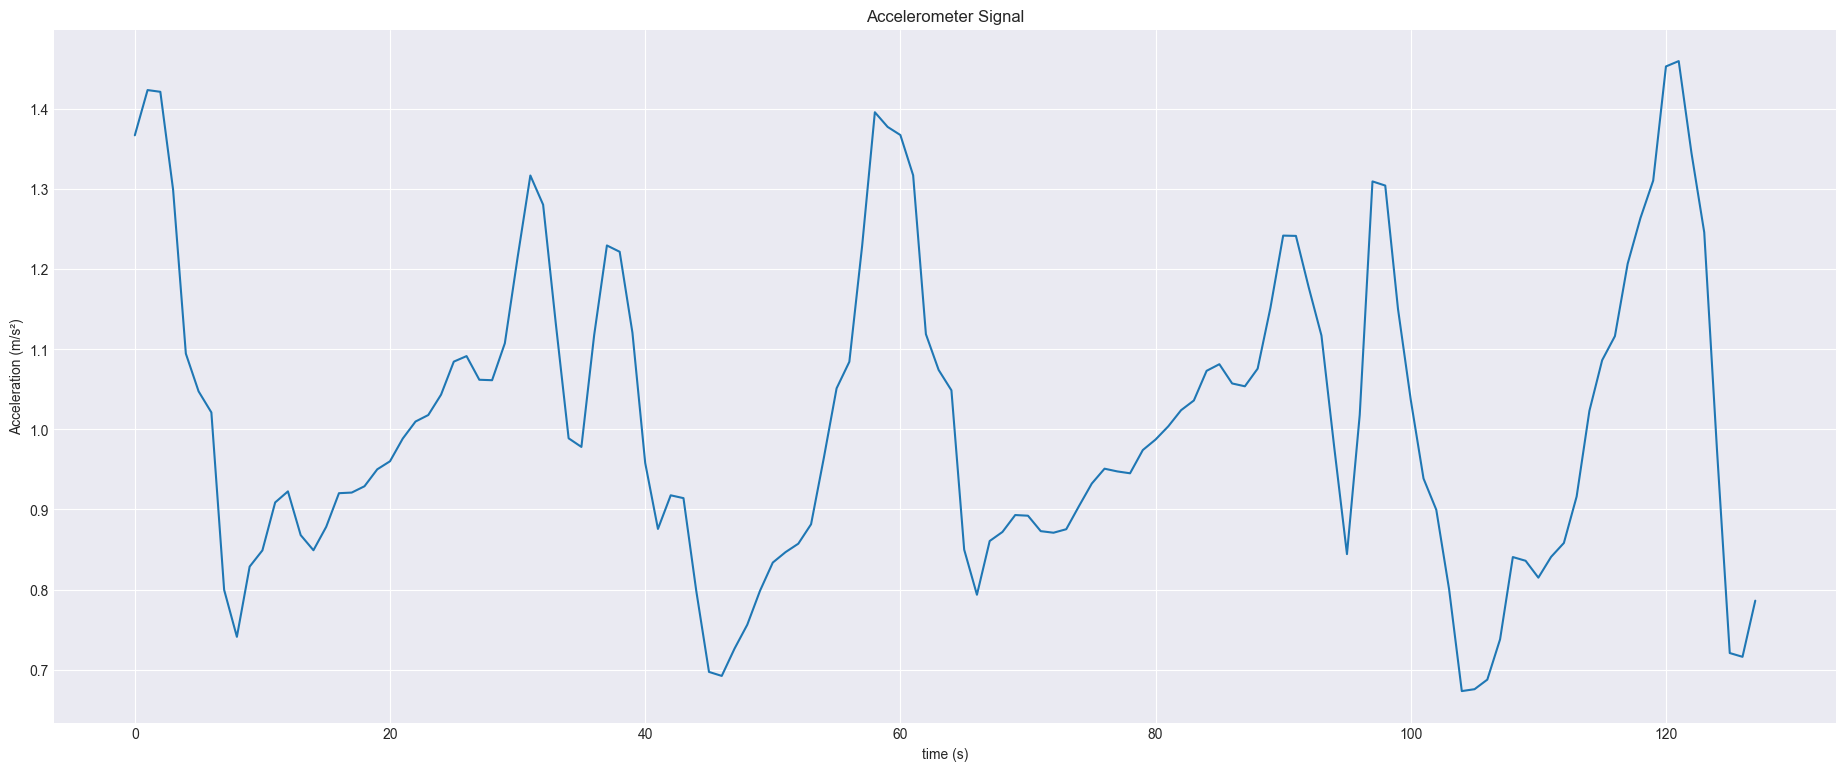

In [7]:
idx = 2000
plt.plot(x_train_sig[idx])
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
print(f"Вид активности: {activity_labels[y_train[idx]]}")

## 2. Classification eval

Будем оценивать качество всех подходов одинаковым образом -- обучим поверх Random Forest и оценим метрики классфикации на тесте

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


def eval_features(X_train, y_train, X_test, y_test):
    classifier = RandomForestClassifier()
    # Train the classifier
    classifier.fit(X_train, y_train.ravel())

    # Predict test data
    y_test_predict = classifier.predict(X_test)

    # Get the classification report
    accuracy = accuracy_score(y_test, y_test_predict) * 100
    print(classification_report(y_test, y_test_predict, target_names=activity_labels))
    print("Accuracy: " + str(accuracy) + "%")

## 3. TSFel



### 3.1 Feature extraction


In [9]:
import tsfel

In [10]:
cfg_file = tsfel.get_features_by_domain()  # All features
# cfg_file = tsfel.get_features_by_domain('statistical') # Only statistical features
# cfg_file = tsfel.get_features_by_domain('temporal')    # Only temporal features
# cfg_file = tsfel.get_features_by_domain('spectral')    # Only spectral features

# Get features
X_train = tsfel.time_series_features_extractor(
    config=cfg_file,  # настрока выделения признаков
    timeseries=x_train_sig,  # ряды
    fs=50,  # частота измерений в Hz
    n_jobs=1, # лично у меня жестко виснет ноут если делать больше джобов, по дефолту там -1
    # Уже сделано составителями датасета
    # window_size=128, # размер окошка для нарезания исходных данных
    # overlap=0.5 # насколько пересекаются соседние окошки
)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=50, n_jobs=1)

In [11]:
X_train.shape

(7352, 156)

### 3.2 Feature selection

In [12]:
from sklearn.feature_selection import VarianceThreshold

In [13]:
# Highly correlated features are removed
corr_features, X_train = tsfel.correlated_features(X_train, drop_correlated=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

### 3.3 Classification

In [14]:
eval_features(X_train, y_train, X_test, y_test)

                    precision    recall  f1-score   support

           WALKING       0.81      0.98      0.89       496
  WALKING_UPSTAIRS       0.84      0.80      0.82       471
WALKING_DOWNSTAIRS       0.94      0.75      0.84       420
           SITTING       0.72      0.47      0.57       491
          STANDING       0.63      0.83      0.72       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.81      2947
         macro avg       0.82      0.81      0.81      2947
      weighted avg       0.82      0.81      0.81      2947

Accuracy: 81.2012215812691%


## 4. Catch22 

### 4.1 Feature extraction

In [15]:
import pycatch22
from tqdm.auto import tqdm
from typing import List

In [16]:
def extract_catch22(
    ts: List[np.array],
    catch24=False,  # mean and standard deviation
):
    X = np.vstack([pycatch22.catch22_all(series, catch24=catch24)["values"] for series in tqdm(ts)])
    return X

In [17]:
X_train = extract_catch22(x_train_sig)
X_test = extract_catch22(x_test_sig)

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

In [18]:
X_train.shape

(7352, 22)

### 4.2 Feature Selection

Этот шаг уже по сути проделан составителями набора признаков -- он и так уже оптимальный

In [19]:
# DONE!!!!

### 4.3 Classification

Качество так себе -- все дело в том что как раз в этой задаче важны mean/std

In [20]:
eval_features(X_train, y_train, X_test, y_test)

                    precision    recall  f1-score   support

           WALKING       0.74      0.93      0.83       496
  WALKING_UPSTAIRS       0.77      0.71      0.74       471
WALKING_DOWNSTAIRS       0.89      0.70      0.78       420
           SITTING       0.41      0.35      0.38       491
          STANDING       0.47      0.60      0.53       532
            LAYING       0.73      0.61      0.67       537

          accuracy                           0.65      2947
         macro avg       0.67      0.65      0.65      2947
      weighted avg       0.66      0.65      0.65      2947

Accuracy: 64.91347132677299%


### 4.4 Feature Extraction (2)

Добавим mean/std

In [21]:
X_train = extract_catch22(x_train_sig, catch24=True)
X_test = extract_catch22(x_test_sig, catch24=True)
eval_features(X_train, y_train, X_test, y_test)

  0%|          | 0/7352 [00:00<?, ?it/s]

  0%|          | 0/2947 [00:00<?, ?it/s]

                    precision    recall  f1-score   support

           WALKING       0.78      0.99      0.87       496
  WALKING_UPSTAIRS       0.85      0.72      0.78       471
WALKING_DOWNSTAIRS       0.92      0.78      0.85       420
           SITTING       0.68      0.52      0.58       491
          STANDING       0.63      0.77      0.70       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.80      2947
         macro avg       0.81      0.80      0.80      2947
      weighted avg       0.81      0.80      0.80      2947

Accuracy: 80.04750593824228%


## 5. TSFresh

### 5.1 Feature extraction

Для начала нужно привести данные к формату библиотеки, похожий вормат мы уже видели на самом первом семинаре
- id -- идентификатор дяра
- time -- временная метка
- value -- значение ряда

In [22]:
df_train = pd.concat(
    [
        pd.DataFrame({"id": i, "time": np.arange(len(x_train_sig[i])), "value": x_train_sig[i]})
        for i in range(len(x_train_sig))
    ],
    axis=0,
)

df_test = pd.concat(
    [
        pd.DataFrame({"id": i, "time": np.arange(len(x_test_sig[i])), "value": x_test_sig[i]})
        for i in range(len(x_test_sig))
    ],
    axis=0,
)

In [23]:
df_train.head()

,id,time,value
0,0,0,1.012817
1,0,1,1.022833
2,0,2,1.022028
3,0,3,1.017877
4,0,4,1.023680


В библиотеке можно как в явном виде задавать нужные фичи и их настройки, так и использовать [предзагатовленные конфиги](https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)

In [24]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters  # Попробуем для начала минимальный набор

X_train = extract_features(
    df_train, default_fc_parameters=MinimalFCParameters(), column_id="id", column_sort="time", n_jobs=1
)
X_test = extract_features(
    df_test, default_fc_parameters=MinimalFCParameters(), column_id="id", column_sort="time", n_jobs=1
)

Feature Extraction: 100%|███████████████████| 2947/2947 [00:00<00:00, 7460.12it/s]


In [25]:
X_train.shape

(7352, 10)

### 5.2 Feature Selection

In [26]:
# Skip: only 10 features

### 5.3 Classification

In [27]:
eval_features(X_train, y_train, X_test, y_test)

                    precision    recall  f1-score   support

           WALKING       0.61      0.74      0.67       496
  WALKING_UPSTAIRS       0.63      0.59      0.61       471
WALKING_DOWNSTAIRS       0.88      0.72      0.79       420
           SITTING       0.64      0.59      0.61       491
          STANDING       0.65      0.69      0.67       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.73      2947
         macro avg       0.73      0.72      0.73      2947
      weighted avg       0.73      0.73      0.73      2947

Accuracy: 72.75195113674924%


### 5.4 Feature extraction(2)

Попробуем более обширный набор признаков

In [28]:
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import EfficientFCParameters

# Оптимальо распределяет ряды по чанкам + можно Dask/Spark
X_train = extract_features(
    df_train, default_fc_parameters=EfficientFCParameters(), column_id="id", column_sort="time", n_jobs=4
)
X_test = extract_features(
    df_test, default_fc_parameters=EfficientFCParameters(), column_id="id", column_sort="time", n_jobs=4
)

Feature Extraction:   0%|                                  | 0/20 [00:00<?, ?it/s]/Users/a.p.chikov/PycharmProjects/time-series-in-action-2025/.venv/lib/python3.11/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/a.p.chikov/PycharmProjects/time-series-in-action-2025/.venv/lib/python3.11/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/a.p.chikov/PycharmProjects/time-series-in-action-2025/.venv/lib/python3.11/site-packages/tsfresh/__init__.py:12: UserWarning: pkg_resources i

In [29]:
X_train.shape

(7352, 777)

### 5.5 Feature Selection(2)

Проводим отбор признаков на основе набора статтестов, везде проверяем гипотезу о независимости признака и таргета

Вид статтеста зависит от типа признака и таргета


In [36]:
from tsfresh import select_features

In [37]:
X_train = X_train.dropna(axis=1, how="all")
X_test = X_test[X_train.columns]

In [38]:
X_train_selected = select_features(
    X_train,
    y_train,
    test_for_binary_target_binary_feature="fisher",
    test_for_binary_target_real_feature="mann",
    test_for_real_target_binary_feature="mann",
    test_for_real_target_real_feature="kendall",
    ml_task="classification",
    n_jobs=1,
)
X_test_selected = X_test[X_train_selected.columns]

In [39]:
X_train_selected.shape

(7352, 417)

### 5.6 Classification(2)

Сравним качество на вариантах с и без отбора признаков -- отбор сделал качество даже чуть лучше (на самом деле разница на уровне рандома)

In [40]:
eval_features(X_train, y_train, X_test, y_test)

                    precision    recall  f1-score   support

           WALKING       0.80      0.97      0.88       496
  WALKING_UPSTAIRS       0.89      0.82      0.85       471
WALKING_DOWNSTAIRS       0.95      0.79      0.86       420
           SITTING       0.72      0.44      0.55       491
          STANDING       0.62      0.84      0.71       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.81      2947
         macro avg       0.83      0.81      0.81      2947
      weighted avg       0.83      0.81      0.81      2947

Accuracy: 81.43875127248049%


In [41]:
eval_features(X_train_selected, y_train, X_test_selected, y_test)

                    precision    recall  f1-score   support

           WALKING       0.80      0.98      0.88       496
  WALKING_UPSTAIRS       0.89      0.82      0.85       471
WALKING_DOWNSTAIRS       0.96      0.79      0.87       420
           SITTING       0.71      0.48      0.57       491
          STANDING       0.63      0.82      0.71       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.82      2947
         macro avg       0.83      0.82      0.81      2947
      weighted avg       0.83      0.82      0.81      2947

Accuracy: 81.8798778418731%


## 6. TS2VEC

### 6.1 Приведем датасет к формату библиотеки

In [44]:
from etna.datasets import TSDataset

In [45]:
df_train = pd.concat(
    [
        pd.DataFrame({"segment": i, "timestamp": np.arange(len(x_train_sig[i])), "target": x_train_sig[i]})
        for i in range(len(x_train_sig))
    ],
    axis=0,
)

df_test = pd.concat(
    [
        pd.DataFrame({"segment": i, "timestamp": np.arange(len(x_test_sig[i])), "target": x_test_sig[i]})
        for i in range(len(x_test_sig))
    ],
    axis=0,
)

ts_train = TSDataset(df=df_train, freq=None)
ts_test = TSDataset(df=df_test, freq=None)

### 6.2 Используем предобученную модель

In [46]:
from etna.transforms import EmbeddingSegmentTransform
from etna.transforms.embeddings.models import TS2VecEmbeddingModel

TS2VecEmbeddingModel.list_models()

['ts2vec_tiny']

In [47]:
ts2vec_pretrained = TS2VecEmbeddingModel.load(path="ts2vec_model.zip", model_name="ts2vec_tiny")
emb_transform = EmbeddingSegmentTransform(in_columns=["target"], embedding_model=ts2vec_pretrained, out_column="emb")

In [48]:
ts_train.transform([emb_transform])
ts_test.transform([emb_transform])
ts_train.head()  # В рамках одного ряда во всех точках признаки константны

segment           0                                                   \
feature       emb_0    emb_1    emb_10    emb_11    emb_12    emb_13   
timestamp                                                              
0         -0.024451 -0.02051 -0.033877 -0.039494 -0.029524 -0.025786   
1         -0.024451 -0.02051 -0.033877 -0.039494 -0.029524 -0.025786   
2         -0.024451 -0.02051 -0.033877 -0.039494 -0.029524 -0.025786   
3         -0.024451 -0.02051 -0.033877 -0.039494 -0.029524 -0.025786   
4         -0.024451 -0.02051 -0.033877 -0.039494 -0.029524 -0.025786   

segment                                            ...      999            \
feature      emb_14    emb_15     emb_2     emb_3  ...   emb_15     emb_2   
timestamp                                          ...                      
0         -0.026319 -0.027209 -0.021556 -0.037697  ... -0.02721 -0.021561   
1         -0.026319 -0.027209 -0.021556 -0.037697  ... -0.02721 -0.021561   
2         -0.026319 -0.027209 -0.021556 -0.037697  ... -0.02721 -0.021561   
3         -0.026319 -0.027209 -0.021556 -0.037697  ... -0.02721 -0.021561   
4         -0.026319 -0.027209 -0.021556 -0.037697  ... -0.02721 -0.021561   

segment                                                               \
feature       emb_3     emb_4     emb_5    emb_6     emb_7     emb_8   
timestamp                                                              
0         -0.037698 -0.017935 -0.033451 -0.02252 -0.017356 -0.030389   
1         -0.037698 -0.017935 -0.033451 -0.02252 -0.017356 -0.030389   
2         -0.037698 -0.017935 -0.033451 -0.02252 -0.017356 -0.030389   
3         -0.037698 -0.017935 -0.033451 -0.02252 -0.017356 -0.030389   
4         -0.037698 -0.017935 -0.033451 -0.02252 -0.017356 -0.030389   

segment                        
feature       emb_9    target  
timestamp                      
0         -0.029219  1.014366  
1         -0.029219  1.011513  
2         -0.029219  1.011935  
3         -0.029219  1.013560  
4         -0.029219  1.012243  

[5 rows x 124984 columns]

### 6.3 Classification

Результат на уровне первого набора признаков из tsfresh -- возможно имеет смысл предобучить модель на таргетных данных

In [49]:
emb_dim = 16

X_train = ts_train.to_pandas(flatten=True)
X_train["segment"] = X_train["segment"].astype(int)
X_train = X_train.sort_values("segment").drop_duplicates(subset=["segment"])[[f"emb_{i}" for i in range(emb_dim)]]

X_test = ts_test.to_pandas(flatten=True)
X_test["segment"] = X_test["segment"].astype(int)
X_test = X_test.sort_values("segment").drop_duplicates(subset=["segment"])[[f"emb_{i}" for i in range(emb_dim)]]

In [50]:
eval_features(X_train, y_train, X_test, y_test)

                    precision    recall  f1-score   support

           WALKING       0.66      0.81      0.73       496
  WALKING_UPSTAIRS       0.66      0.63      0.65       471
WALKING_DOWNSTAIRS       0.85      0.67      0.75       420
           SITTING       0.66      0.51      0.58       491
          STANDING       0.63      0.75      0.68       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.74      2947
         macro avg       0.74      0.73      0.73      2947
      weighted avg       0.74      0.74      0.73      2947

Accuracy: 73.63420427553444%
